In [17]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
import math

from sklearn.metrics import accuracy_score

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")

In [19]:

train_path = ('/content/drive/MyDrive/data_folder/Training')
test_path = ('/content/drive/MyDrive/data_folder/Testing')

# Новый раздел

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [21]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform),
    batch_size=32, shuffle=True,
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=32, shuffle=True
)

In [22]:
class ConvNet1(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Linear(32*26*26, num_classes)
        self.lsm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        out = self.lsm(out)
        return out

In [23]:
scores_train = []
scores_test = []
bin_train_label = []
bin_test_label = []

In [24]:
nn_light = ConvNet1(num_classes=4).to(device)
nn_light.load_state_dict(torch.load('/content/drive/MyDrive/cnn_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [25]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    model.train()
    correct = 0
    total = 0

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            if epoch == epochs-1:
                for prob in outputs.data:
                    scores_train.append(math.exp(prob[2]))
                for lab in labels:
                    if (lab == 2):
                        bin_train_label.append(True)
                    else:
                        bin_train_label.append(False)
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {accuracy:.2f}%")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for prob in outputs.data:
                scores_test.append(math.exp(prob[2]))
            for lab in labels:
                if (lab == 2):
                    bin_test_label.append(True)
                else:
                    bin_test_label.append(False)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [26]:
train(nn_light, train_loader, epochs=2, learning_rate=0.001, device=device)
test_accuracy_light = test(nn_light, test_loader, device)

Epoch 1/2, Loss: 0.0303885889678592, Train Accuracy: 98.75%
Epoch 2/2, Loss: 0.04353145921551105, Train Accuracy: 98.68%
Test Accuracy: 74.11%


In [27]:
scores_test = np.log(scores_test)
scores_train = np.log(scores_train)

In [28]:
from scipy.stats import binom
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests
from bisect import bisect
import numpy as np
import torch

def hb_p_value(r_hat, n, alpha=0.1):
    bentkus_p_value = np.e * binom.cdf(np.ceil(n * r_hat), n, alpha)
    def h1(y,mu):
        with np.errstate(divide='ignore'): return y * np.log(y/mu) + (1-y) * np.log((1-y)/(1-mu))

    hoeffding_p_value = np.exp(-n * h1(min(r_hat, alpha), alpha))
    return min(bentkus_p_value, hoeffding_p_value)


def bonferroni(p_values,delta):
    rejections, _, _, _ = multipletests(p_values,delta,method='holm',is_sorted=False,returnsorted=False)
    print(rejections)
    R = np.nonzero(rejections)[0]
    return R

# Procedure to calculate q-values with using p-value, true labels not used.
def calculate_qvalues_from_pvalues(distribution, query, pi_0=0.9):
    p_values = empirical_p_values(np.sort(distribution), query)
    q_values = p_values*len(p_values)*pi_0
    q_values = q_values/np.arange(1, len(p_values)+1)
    for i in range(len(p_values)-1,0,-1):
        q_values[i-1] = min(q_values[i-1], q_values[i])

    return q_values

def calculate_fdr(scores, labels):
    scores_data = []
    for i in range(len(scores)):
        scores_data.append((scores[i], labels[i]))
    scores_data.sort(key=lambda x: x[0])
    sort_data = scores_data[::-1]
    scores.sort()
    scores = scores[::-1]
    sorted_test_labels = []
    for i in range(len(scores)):
        sorted_test_labels.append(scores_data[i][1])

    negative = 0
    positive = 0
    fdr = []
#     for label in sorted_test_labels:
#         negative += label == 0
#         positive += label == 1
#         fdr.append(negative / (negative+positive) )
    for score in scores:
        if score > np.log(0.5):
            label = True
        else:
            label = False
        negative += label == 0
        positive += label == 1
        fdr.append(negative / (negative+positive) )
    return np.array(fdr)


def calculate_qvalues_from_labels(scores, labels):
    qvalue = calculate_fdr(scores, labels)
    for i in range(len(qvalue)-1, 0, -1):
        qvalue[i-1] = min(qvalue[i], qvalue[i-1])
    return qvalue


def empirical_p_values(distribution, query):
    dist_len = len(distribution)
    query_len = len(query)
    p_values = np.zeros([query_len,])
    for i, score in enumerate(query):
        p_values[i] = (dist_len-bisect(distribution, score))/dist_len
    return np.sort(p_values)

import numpy as np

def calculate_ltt(scores, bin_train_label, bin_test_label, right_board):
    train_fdrs = calculate_fdr(scores['train'], bin_train_label)
    lambdas = np.array(len(scores['train']) * np.linspace(0, 1., 300), dtype=int)[:-1]
    r_hats = train_fdrs[lambdas]
    plt_data = []
    train_prob_scores = np.array(scores['train'])
    test_prob_scores = np.array(scores['test'])
    for alpha in tqdm(np.linspace(0.001, right_board, 100)):
        pvalues = np.array([hb_p_value(r_hat, len(scores['train']), alpha=alpha) for r_hat in r_hats])
        print(pvalues)
        chosen = lambdas[bonferroni(pvalues, 0.15)] / len(bin_train_label) * len(bin_test_label)
        chosen_score = np.sort(train_prob_scores)[::-1][lambdas[bonferroni(pvalues, 0.5)][-1]]
        idx_score = np.sum(test_prob_scores > chosen_score)
        idx = int(chosen[-1])
        plt_data.append((idx, idx_score, alpha))
    return plt_data


In [29]:
scores = {'train': np.array(scores_train), 'test': np.array(scores_test)}
bin_train_label = np.array(bin_train_label)
bin_test_label = np.array(bin_test_label)

train_score_neg = scores_train[bin_train_label == 0]
test_score_neg = scores_test[bin_test_label == 0]
train_score_pos = scores_train[bin_train_label != 0]
test_score_pos = scores_test[bin_test_label != 0]

In [30]:
qvalues_epv = calculate_qvalues_from_pvalues(train_score_neg, scores['test'])
qvalues_true = calculate_qvalues_from_labels(scores['test'], bin_test_label)

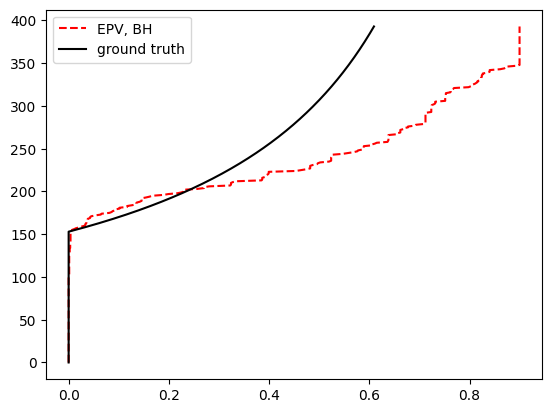

In [33]:
plt.plot(qvalues_epv, np.arange(len(qvalues_epv)), 'r--', label='EPV, BH', markeredgewidth=10)
plt.plot(qvalues_true, np.arange(len(qvalues_true)), color='black', label='ground truth')
plt.legend()
plt.show()